In [2]:
import refitter as rf
reload(rf)

import ROOT as RT
# RT.gROOT.LoadMacro("~/rootlogon.C")
RT.gStyle.SetOptStat(0)
RT.gStyle.SetPalette(RT.kGreenPink)
import numpy as np

#import pyrapp as pya
#reload(pya)
#app = pya.PyRApp([],args=["-O","plots"])
#app.options.saveas=["root","pdf"]
#def save(obj):
#    app.keep(obj,format=True)
#    app.save(True)

import matplotlib.pyplot as plt
    
import root_pandas as rpd
import pandas as pd

#%matplotlib notebook
%matplotlib inline
#%jsroot on
%jsroot off

In [3]:
inputDir="/eos/user/m/musella/data/mod_dep_005"
fname = inputDir+"/output_InsideAcceptance_125.root"
pfx = "genDiphotonDumper/trees/InsideAcceptance_125_13TeV"

trees = map(lambda x: "genDiphotonDumper/trees/InsideAcceptance_125_13TeV_SigmaMpTTag_%d" %x, xrange(3))
gtree = "genDiphotonDumper/trees/InsideAcceptance_125_13TeV_NoTag_0"

genBranches = ["genPt","genRapidity",
            "genJet2p5Pt0","genJet2p5Rapidity0",
            "genJet2p5Pt1","genJet2p5Rapidity1",
            "genJet2p5Pt2","genJet2p5Rapidity3",
            "genJet2p5Pt2","genJet2p5Rapidity3",
            "weight",
            "genNjets2p5","recoNjets2p5"
           ]
recoBranches = ['recoPt','recoRapidity']

dfs = [rpd.read_root(fname,gtree,columns=genBranches)]+map(lambda x: 
                                                           rpd.read_root(fname,x,columns=genBranches+recoBranches), trees )

In [4]:
def setclass_and_weight(x):
    cls,df = x
    cls -= 1
    
    df['class'] = np.full(df.index.size,cls,dtype=np.int8)

    df['absweight'] = np.abs(df['weight'])
    df.weight_column = df['absweight'] 

map(setclass_and_weight,enumerate(dfs))

df = pd.concat(dfs)

In [5]:
X,y,w = df[['genPt','genRapidity']],df[['class']],df['absweight']



In [6]:
from sklearn import ensemble
from sklearn import cross_validation

In [7]:
X_train, X_test, y_train, y_test, w_train, w_test = cross_validation.train_test_split(X,y,w)

In [9]:
clf = ensemble.GradientBoostingClassifier(verbose=1,max_depth=10,learning_rate=0.02,n_estimators=2000,min_weight_fraction_leaf=1e-4,warm_start=True)

In [10]:
clf

GradientBoostingClassifier(init=None, learning_rate=0.02, loss='deviance',
              max_depth=10, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0001, n_estimators=2000,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=True)

In [11]:
clf.fit(X_train[:100000], y_train[:100000],w_train[:100000])
#clf.fit(X_train, y_train,w_train)

GradientBoostingClassifier(init=None, learning_rate=0.02, loss='deviance',
              max_depth=10, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0001, n_estimators=2000,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=True)

      Iter       Train Loss   Remaining Time 
         1      164227.4883           49.24m
         2      164263.3785           46.33m
         3      164304.0806           45.18m
         4      164348.4254           44.75m
         5      164395.4959           44.37m
         6      164446.3504           44.16m
         7      164500.3402           43.87m
         8      164557.4160           43.71m
         9      164615.9458           43.58m
        10      164675.5107           43.40m
        20      165412.7543           42.59m
        30      166253.7381           41.97m
        40      167097.5407           41.20m
        50      167904.6074           40.27m
        60      168648.5849           39.39m
        70      169310.4589           38.73m
        80      169912.7715           38.05m
        90      170438.5455           37.18m
       100      170897.0522           36.21m
       200      173169.6436           29.25m
       300      173752.5248           25.69m
       40

/cvmfs/sft.cern.ch/lcg/views/LCG_85swan3/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
y_predict = clf.predict(X_test)
y_predict_proba = clf.predict_proba(X_test)

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [15]:
# help(df)

# cm = confusion_matrix(y_test,y_predict)#,sample_weight=w_test)

In [16]:
nevts = np.array(map(lambda x: float(x.index.size), dfs))
nevts

sumw = np.array(map(lambda x: float(x['weight'].sum()), dfs))
sumw

sumaw = np.array(map(lambda x: float(x['absweight'].sum()), dfs))
sumaw

array([ 52.85478273,  18.28185768,  22.26703505,  36.96963906])

In [17]:
nevts / nevts.sum()

array([ 0.40175572,  0.14324487,  0.17232713,  0.28267228])

In [18]:
sumw / sumw.sum()

array([ 0.4066704 ,  0.13786606,  0.17104098,  0.28442256])

In [19]:
sumaw / sumaw.sum()

array([ 0.40541105,  0.14022699,  0.17079442,  0.28356753])

In [20]:
y_predict_proba

array([[  4.72323547e-01,   9.91404250e-04,   7.29103881e-02,
          4.53774661e-01],
       [  6.00332122e-01,   7.70307287e-04,   1.80886624e-01,
          2.18010946e-01],
       [  2.97006384e-01,   2.39792555e-02,   2.28372145e-01,
          4.50642215e-01],
       ..., 
       [  3.87632393e-01,   2.61473842e-01,   2.61152896e-01,
          8.97408688e-02],
       [  5.88132375e-01,   5.95663789e-04,   1.43161932e-03,
          4.09840342e-01],
       [  4.11911112e-01,   6.21343517e-04,   8.37405933e-03,
          5.79093485e-01]])

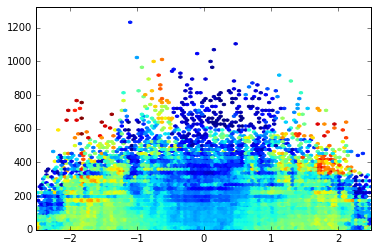

In [21]:
plt.figure()
plt.hexbin(x=X_test['genRapidity'],y=X_test['genPt'],C=y_predict_proba[:,0])
plt.show()

In [22]:
ptmax  = 300.
npt = 300
ptstep = ptmax/npt
pt0 = 0.5*ptstep

rapmax = 3.
nrap = 300
rapstep = rapmax/nrap
rap0 = 0.5*rapstep


ptbinsc = np.arange(pt0,ptmax,ptstep)
rapbinsc = np.arange(rap0,rapmax,rapstep)


In [23]:
import itertools

grid = np.array(list(itertools.product(ptbinsc,rapbinsc)))

In [24]:
predict_grid = clf.predict_proba(grid)
sel_eff = map(np.sum, predict_grid[:,1:])

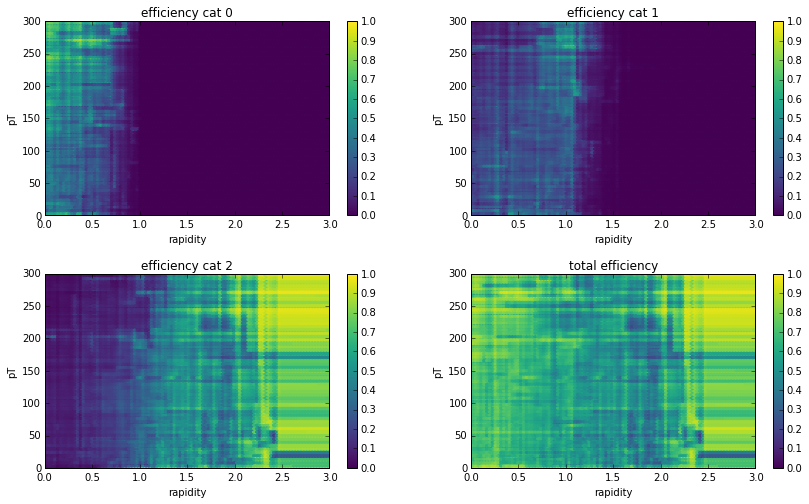

In [25]:
plt.figure(figsize=(14,8))

cmap=cmap=plt.cm.viridis

for iclass in xrange(3):
    plt.subplot(2, 2, iclass+1)

    plt.hexbin(y=grid[:,0],x=grid[:,1],C=predict_grid[:,iclass+1],cmap=cmap,vmin=0,vmax=1)
    plt.ylabel("pT")
    plt.xlabel("rapidity")
    plt.title("efficiency cat %d" % iclass)
    plt.colorbar()
    #plt.colorbar()

plt.subplot(2, 2, 4)
plt.hexbin(y=grid[:,0],x=grid[:,1],C=sel_eff,cmap=cmap,vmin=0,vmax=1)
plt.ylabel("pT")
plt.xlabel("rapidity")
plt.title("total efficiency")
plt.subplots_adjust(hspace=0.3)

plt.colorbar()
plt.show()
plt.savefig("plots/gbr_eff.pdf")

In [27]:
import pickle

In [28]:
s = pickle.dumps(clf)

In [30]:
with gopen('gbr_test.pkl','w+') as fout:
    fout.write(s)
    fout.close()

In [31]:
from gzip import open as gopen

In [32]:
with gopen('gbr_test.pkl.gz') as fin:
    clf2 = pickle.load(fin)

In [33]:
predict_grid2 = clf2.predict_proba(grid)

In [34]:
(predict_grid-predict_grid2).sum()

0.0

In [35]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

In [36]:
params_grid = { "max_depth" : [3,5,7],
                "learning_rate" : [0.02, 0.1, 0.2],
                "n_estimators" : [100,200,500,1000],
                "min_weight_fraction_leaf" : [ 1e-3, 1e-2, 1e-1]
              }

In [68]:
gclf = RandomizedSearchCV(ensemble.GradientBoostingClassifier(),params_grid,cv=5)

In [ ]:
gclf.fit(X_train[:100000], y_train[:100000]['class'])

In [ ]:
print("Best parameters set found on development set:")
print()
print(gclf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in gclf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print()

In [ ]:
gclf.best_params_

In [ ]:
gclf.grid_scores_

In [ ]:
clfo = ensemble.GradientBoostingClassifier(verbose=1,**gclf.best_params_)

In [ ]:
clfo.fit(X_train[:100000], y_train[:100000]['class'],w_train[:100000])

In [ ]:
predict_grido = clfo.predict_proba(grid)


In [ ]:
pdedict_diff = predict_grido- predict_grid

In [ ]:
plt.figure()

for iclass in xrange(3):
    plt.subplot(2, 2, iclass+1)

    plt.hexbin(y=grid[:,0],x=grid[:,1],C=predict_grid_diff[:,iclass+1],cmap=cmap,vmin=-2,vmax=2)
    plt.ylabel("pT")
    plt.xlabel("rapidity")
    plt.title("efficiency cat %d" % iclass)
    plt.colorbar()
    #plt.colorbar()
    